# 학습 관련 기술들

## 매개변수 갱신

### 모험가 이야기
### 확률적 경사 하강법(SGD)

In [1]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

* SGD 클래스를 활용한 신경망 매개변수 진행

        network = TwoLayerNet(...)
        optimizer = SGD()

        for i in range(10000):
            ...
            x_batch, t_batch = get_mini_batch(...) # 미니 배치
            grads = network.gradient(x_batch, t_batch)
            params = network.params
            optimizer.update(params, grads)
            ...
* optimizer : 최적화를 행하는 자
SGD()가 그 역할을 한다.  
매개변수 갱신을 optimizer가 하고, 사용자가 매개변수와 기울기 정보를 optimizer에 입력한다.
* 최적화 담당 클래스를 분리해서 구현하면 모듈화 하기 좋다.  
optimizer = SGD()  
optimizer = Momentum() : SGD가 모멘텀으로 바뀐다.
* Lasagne 딥러닝 프레임워크 : updates.py 에 최적화 기법을 구현.

### SGD의 단점
문제에 따라 비효율적일 때가 있다.  
다음 함수의 최솟값 구하는 문제
$$f(x,y) = {1 \over 20}x^2 + y^2$$

* 함수의 그래프(왼쪽), 등고선(오른쪽)
![img](./deep_learning_images/fig_6-1.png)

* 함수의 기울기
![img](./deep_learning_images/fig_6-2.png)
y축 방향이 크고, x축 방향은 작다.  

* 주의할 점
    * 최솟값이 되는 장소는 $(x,y) = (0,0)$이지만 그림의 기울기는 대부분 원점을 가리키지 않는다.
    
* SGD 적용  
초깃값을 $(x,y) = (-7.0,2.0)$으로 지정한다.
![img](./deep_learning_images/fig_6-3.png)
최솟값인 원점까지 지그재그로 이동한다. 비효율적이다.  
심하게 굽어진 움직임을 보여준다.  
* SGD 단점
    * 비등방성(anisotropy) 함수(기울기가 달라지는 함수)에서 탐색 경로가 비효율적이다.
    * 근본 원인 : 기울어진 방향이 본래의 최솟값과 다른 방향을 가리킨다.
    
* 개선한 방법
    * 모멘텀, AdaGrad, Adam 소개

### 모멘텀
모멘텀(momentum)

In [4]:
class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None #v : 물체의 속도
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
            for key in params.keys():
                self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
                params[key] += self.v[key]

모멘텀에 의한 최적화 갱신 경로
![img](./deep_learning_images/fig_6-5.png)
SGD 보다 지그재그 정도가 덜하다.  
> x축의 힘이 아주 작지만 방향이 변하지 않아서, 한 방향으로 일정하게 가속하기 때문이다.

### AdaGrad

$$\mathbf{h} \leftarrow \mathbf{h} + {\partial L \over \partial \mathbf{W}} \odot {\partial L \over \partial \mathbf{W}} \\
\mathbf{W} \leftarrow \mathbf{W} - \eta{1 \over \sqrt{\mathbf{h}}} {\partial L \over \partial \mathbf{W}}$$

In [6]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params, items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

![img](./deep_learning_images/fig_6-6.png)



### Adam
모멘텀과 AdaGrad 기법을 융합한 것이 Adam이다.
![img](./deep_learning_images/fig_6-7.png)


### 어느 갱신 방법을 사용할 것인가?

!cat ./optimizer_compare_naive.py

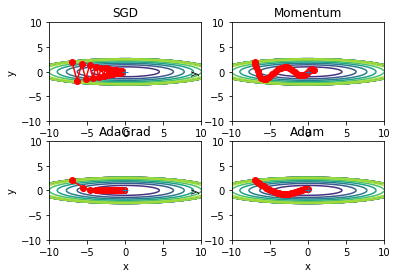

In [5]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

### MNIST 데이터셋으로 본 갱신 방법 비교

![img](./deep_learning_images/fig_6-9.png)

In [14]:
!cat ./optimizer_compare_mnist.py

# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mas

===========iteration:0===========
SGD:2.3757757445988608
Momentum:2.4162505748192435
AdaGrad:2.2728849773942574
Adam:2.2106253942392473
===========iteration:100===========
SGD:1.6123899698557271
Momentum:0.4843754556199362
AdaGrad:0.20499811075411178
Adam:0.3082134723396134
===========iteration:200===========
SGD:0.7688347081952884
Momentum:0.2627467680944161
AdaGrad:0.11360801320429893
Adam:0.18716150159298633
===========iteration:300===========
SGD:0.5288945951140969
Momentum:0.18918863216983495
AdaGrad:0.09725890158859431
Adam:0.19470465726295846
===========iteration:400===========
SGD:0.46895681686403945
Momentum:0.1791678538416655
AdaGrad:0.07214446210071083
Adam:0.12093770021401407
===========iteration:500===========
SGD:0.33462355458509835
Momentum:0.11314466995765489
AdaGrad:0.04887259498804277
Adam:0.053258493426529815
===========iteration:600===========
SGD:0.23964637452157278
Momentum:0.10917400833645792
AdaGrad:0.03987277218890167
Adam:0.04340888291017238
===========iterati

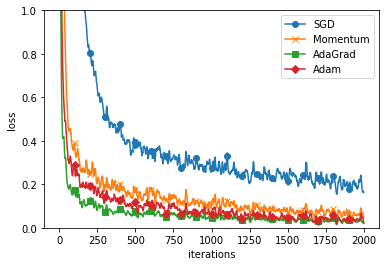

In [7]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 가중치의 초깃값
### 초깃값을 0으로 하면?
가중치 감소(weight decay)
### 은닉층의 활성화값 분포

In [9]:
# 은닉층의 활성화 함수의 출력 데이터 분포 : 중요한 정보 제공
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1+ np.exp(-x)) # 시그모이드

x = np.random.randn(1000, 100) # 1000개 데이터
node_num = 100 # 은닉층별 노드(뉴런) 수
hidden_layer_size = 5 # 은닉층이 5개
activations = {} #활성화값 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

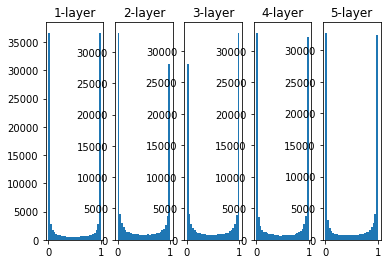

In [12]:
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0,1))
plt.show()

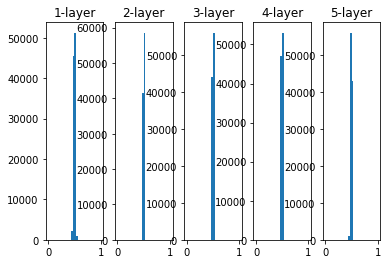

In [13]:
# 표준편차 0.01로 변경
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 0.01 #표준편차가 1 -> 0.01로 변경
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0,1))
plt.show()

0.5 부근에 집중되어, 0과 1로 치우치진 않아서 기울기 소실(gradient vanishing) 문제는 발생하지 않았다.
다만, 활성화 값이 집중되다(=치우치다)는 것은 **표현력을 제한**한다는 점에서 문제가 된다.

* Xavier 초깃값  
일반적인 딥러닝 프레임워크에서 표준 이용하는 가중치 초깃값  
* 앞 계층의 노드가 n 개이면, 표준편차는 $1 \over \sqrt{n}$ 인 분포를 사용하라  
![img](./deep_learning_images/fig_6-12.png)

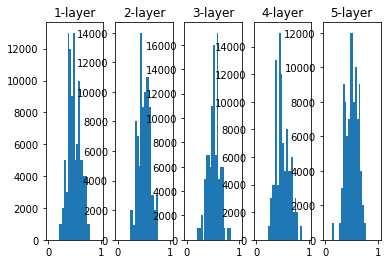

In [16]:
# 표준편차 0.01로 변경
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) #표준편차가 1 -> 1/n로 변경
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0,1))
plt.show()



Xavier 초깃값 사용시  
* 층이 깊어지면서 형태가 다소 일그러짐
* 앞보다 확실히 넓게 분포가 된다. 적당히 퍼진다.  
= 표현력이 제한받지 않는다.  
+ 학습이 효율적이다.

### ReLU를 사용할 때의 가중치 초깃값
* He 초깃값  
앞 계층의 노드가 n개일 때, 표준편차가 $\sqrt{2 \over n}$인 정규분포를 사용한다.  
* std = 0.01, Xavier, He 비교
![img](./deep_learning_images/fig_6-14.png)
* ReLU 활성화 함수는 He 초깃값
* sigmoid, tanh(S자 모양 곡선) 활성화 함수는 Xavier 초깃값

### MNIST 데이터셋으로 본 가중치 초깃값 비교

In [17]:
!cat ./weight_init_compare.py

# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[

===========iteration:0===========
std=0.01:2.302528957393297
Xavier:2.299339193510666
He:2.3527983881737065
===========iteration:100===========
std=0.01:2.3010423364913777
Xavier:2.250396227711919
He:1.4359730865031397
===========iteration:200===========
std=0.01:2.30187505420755
Xavier:2.2019193413503935
He:0.6384638621089236
===========iteration:300===========
std=0.01:2.301046122968586
Xavier:2.0372005209402917
He:0.5987732178942577
===========iteration:400===========
std=0.01:2.3005971462900874
Xavier:1.765827473204948
He:0.5627584484922814
===========iteration:500===========
std=0.01:2.304830525068903
Xavier:1.1890336116137044
He:0.43224665936201245
===========iteration:600===========
std=0.01:2.3036172746856685
Xavier:0.7863173912746768
He:0.39599694718799805
===========iteration:700===========
std=0.01:2.3024157777278402
Xavier:0.607149338982681
He:0.35932309251178574
===========iteration:800===========
std=0.01:2.301050035191076
Xavier:0.5217081929815413
He:0.34561611865442726


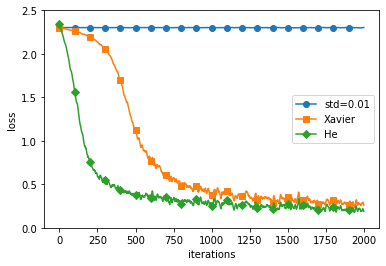

In [18]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## 배치 정규화
배치 정규화(Batch Normalization)
### 배치 정규화 알고리즘
* 주목받는 이유
    * 학습 속도 개선
    * 초깃값 크게 의존하지 않음
    * 오버피팅 억제(드롭아웃 필요성 감소)
    
$$\mu_B \leftarrow {1 \over m} \sum_{i=1}^m x_i \\
\sigma_B^2 \leftarrow \sum_{i=1}^m(x_i - \mu_B)^2 \\
\hat{x}_i \leftarrow {x_i - \mu_B \over \sqrt{\sigma_B^2 + \epsilon}}$$

* 배치 정규화에 의한 데이터 고유 확대(scale), 이동(shift) 변환  
$$ y_i \leftarrow \gamma\hat{x}_i + \beta$$
$\gamma$ 확대(scale), $\beta$ 이동(shift)  
* 배치 정규화의 계산 그래프
![img](./deep_learning_images/fig_6-17.png)



============== 1/16 ==============
epoch:0 | 0.105 - 0.091
epoch:1 | 0.097 - 0.103


/Users/statstics/Desktop/Deep_Learning_From_Scratch1/강호현/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:2 | 0.097 - 0.138
epoch:3 | 0.097 - 0.189
epoch:4 | 0.097 - 0.217
epoch:5 | 0.097 - 0.224
epoch:6 | 0.097 - 0.256
epoch:7 | 0.097 - 0.26
epoch:8 | 0.097 - 0.288
epoch:9 | 0.097 - 0.298
epoch:10 | 0.097 - 0.307
epoch:11 | 0.097 - 0.318
epoch:12 | 0.097 - 0.343
epoch:13 | 0.097 - 0.363
epoch:14 | 0.097 - 0.379
epoch:15 | 0.097 - 0.388
epoch:16 | 0.097 - 0.398
epoch:17 | 0.097 - 0.414


No handles with labels found to put in legend.


epoch:18 | 0.097 - 0.426
epoch:19 | 0.097 - 0.439
============== 2/16 ==============
epoch:0 | 0.092 - 0.146
epoch:1 | 0.097 - 0.147
epoch:2 | 0.097 - 0.146
epoch:3 | 0.097 - 0.154
epoch:4 | 0.097 - 0.183
epoch:5 | 0.097 - 0.206
epoch:6 | 0.097 - 0.237
epoch:7 | 0.097 - 0.259
epoch:8 | 0.097 - 0.288
epoch:9 | 0.097 - 0.306
epoch:10 | 0.097 - 0.332
epoch:11 | 0.097 - 0.365
epoch:12 | 0.097 - 0.38
epoch:13 | 0.097 - 0.399
epoch:14 | 0.097 - 0.423
epoch:15 | 0.097 - 0.447
epoch:16 | 0.097 - 0.463
epoch:17 | 0.097 - 0.479
epoch:18 | 0.097 - 0.494


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.521
============== 3/16 ==============
epoch:0 | 0.1 - 0.097
epoch:1 | 0.381 - 0.128
epoch:2 | 0.504 - 0.159
epoch:3 | 0.564 - 0.192
epoch:4 | 0.605 - 0.22
epoch:5 | 0.676 - 0.254
epoch:6 | 0.738 - 0.289
epoch:7 | 0.749 - 0.325
epoch:8 | 0.793 - 0.37
epoch:9 | 0.834 - 0.406
epoch:10 | 0.861 - 0.444
epoch:11 | 0.884 - 0.476
epoch:12 | 0.885 - 0.511
epoch:13 | 0.903 - 0.527
epoch:14 | 0.926 - 0.552
epoch:15 | 0.93 - 0.569
epoch:16 | 0.948 - 0.596
epoch:17 | 0.952 - 0.618
epoch:18 | 0.955 - 0.627


No handles with labels found to put in legend.


epoch:19 | 0.965 - 0.641
============== 4/16 ==============
epoch:0 | 0.117 - 0.129
epoch:1 | 0.267 - 0.142
epoch:2 | 0.417 - 0.206
epoch:3 | 0.519 - 0.265
epoch:4 | 0.597 - 0.333
epoch:5 | 0.653 - 0.379
epoch:6 | 0.681 - 0.43
epoch:7 | 0.718 - 0.481
epoch:8 | 0.756 - 0.52
epoch:9 | 0.776 - 0.564
epoch:10 | 0.776 - 0.599
epoch:11 | 0.792 - 0.635
epoch:12 | 0.82 - 0.663
epoch:13 | 0.836 - 0.679
epoch:14 | 0.848 - 0.69
epoch:15 | 0.848 - 0.714
epoch:16 | 0.861 - 0.741


No handles with labels found to put in legend.


epoch:17 | 0.864 - 0.758
epoch:18 | 0.879 - 0.771
epoch:19 | 0.882 - 0.788
============== 5/16 ==============
epoch:0 | 0.091 - 0.127
epoch:1 | 0.093 - 0.173
epoch:2 | 0.098 - 0.31
epoch:3 | 0.106 - 0.439
epoch:4 | 0.109 - 0.527
epoch:5 | 0.115 - 0.586
epoch:6 | 0.117 - 0.644
epoch:7 | 0.119 - 0.672
epoch:8 | 0.128 - 0.696
epoch:9 | 0.133 - 0.727
epoch:10 | 0.143 - 0.753
epoch:11 | 0.146 - 0.776
epoch:12 | 0.155 - 0.79
epoch:13 | 0.153 - 0.812
epoch:14 | 0.165 - 0.822
epoch:15 | 0.175 - 0.834
epoch:16 | 0.197 - 0.85
epoch:17 | 0.203 - 0.861
epoch:18 | 0.211 - 0.872


No handles with labels found to put in legend.


epoch:19 | 0.233 - 0.875
============== 6/16 ==============
epoch:0 | 0.126 - 0.11
epoch:1 | 0.1 - 0.205
epoch:2 | 0.118 - 0.437
epoch:3 | 0.113 - 0.593
epoch:4 | 0.117 - 0.666
epoch:5 | 0.121 - 0.743
epoch:6 | 0.117 - 0.779
epoch:7 | 0.117 - 0.808
epoch:8 | 0.117 - 0.842
epoch:9 | 0.117 - 0.859
epoch:10 | 0.117 - 0.869
epoch:11 | 0.117 - 0.883
epoch:12 | 0.117 - 0.895
epoch:13 | 0.117 - 0.904
epoch:14 | 0.117 - 0.916
epoch:15 | 0.117 - 0.922
epoch:16 | 0.117 - 0.929
epoch:17 | 0.117 - 0.934
epoch:18 | 0.117 - 0.943


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.948
============== 7/16 ==============
epoch:0 | 0.149 - 0.14
epoch:1 | 0.116 - 0.354
epoch:2 | 0.116 - 0.645
epoch:3 | 0.117 - 0.72
epoch:4 | 0.117 - 0.765
epoch:5 | 0.117 - 0.812
epoch:6 | 0.117 - 0.827
epoch:7 | 0.117 - 0.846
epoch:8 | 0.116 - 0.877
epoch:9 | 0.116 - 0.893
epoch:10 | 0.116 - 0.92
epoch:11 | 0.116 - 0.935
epoch:12 | 0.116 - 0.946
epoch:13 | 0.116 - 0.961
epoch:14 | 0.116 - 0.974
epoch:15 | 0.116 - 0.98
epoch:16 | 0.116 - 0.984


No handles with labels found to put in legend.


epoch:17 | 0.116 - 0.988
epoch:18 | 0.117 - 0.988
epoch:19 | 0.117 - 0.991
============== 8/16 ==============
epoch:0 | 0.117 - 0.131
epoch:1 | 0.117 - 0.501
epoch:2 | 0.116 - 0.731
epoch:3 | 0.117 - 0.782
epoch:4 | 0.117 - 0.827
epoch:5 | 0.116 - 0.847
epoch:6 | 0.117 - 0.88
epoch:7 | 0.117 - 0.906
epoch:8 | 0.117 - 0.95
epoch:9 | 0.116 - 0.964
epoch:10 | 0.117 - 0.977
epoch:11 | 0.117 - 0.984
epoch:12 | 0.117 - 0.985
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.998
epoch:15 | 0.117 - 0.998
epoch:16 | 0.117 - 0.998
epoch:17 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:18 | 0.117 - 1.0
epoch:19 | 0.117 - 0.999
============== 9/16 ==============
epoch:0 | 0.117 - 0.146
epoch:1 | 0.117 - 0.509
epoch:2 | 0.117 - 0.649
epoch:3 | 0.117 - 0.739
epoch:4 | 0.117 - 0.836
epoch:5 | 0.117 - 0.936
epoch:6 | 0.117 - 0.952
epoch:7 | 0.117 - 0.966
epoch:8 | 0.117 - 0.984
epoch:9 | 0.117 - 0.985
epoch:10 | 0.117 - 0.994
epoch:11 | 0.117 - 0.997
epoch:12 | 0.117 - 0.997
epoch:13 | 0.117 - 0.999
epoch:14 | 0.117 - 0.999
epoch:15 | 0.117 - 1.0
epoch:16 | 0.117 - 1.0
epoch:17 | 0.117 - 1.0
epoch:18 | 0.117 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.117 - 1.0
============== 10/16 ==============
epoch:0 | 0.116 - 0.142
epoch:1 | 0.116 - 0.691
epoch:2 | 0.117 - 0.746
epoch:3 | 0.116 - 0.829
epoch:4 | 0.116 - 0.917
epoch:5 | 0.116 - 0.916
epoch:6 | 0.116 - 0.964
epoch:7 | 0.116 - 0.985
epoch:8 | 0.116 - 0.981
epoch:9 | 0.116 - 0.991
epoch:10 | 0.116 - 0.993
epoch:11 | 0.116 - 0.995
epoch:12 | 0.116 - 0.997
epoch:13 | 0.116 - 0.997
epoch:14 | 0.116 - 0.998
epoch:15 | 0.116 - 0.998
epoch:16 | 0.116 - 0.999
epoch:17 | 0.116 - 0.999
epoch:18 | 0.116 - 0.999
epoch:19 | 0.116 - 0.999


No handles with labels found to put in legend.


============== 11/16 ==============
epoch:0 | 0.097 - 0.174
epoch:1 | 0.105 - 0.514
epoch:2 | 0.117 - 0.566
epoch:3 | 0.116 - 0.664
epoch:4 | 0.116 - 0.775
epoch:5 | 0.116 - 0.807
epoch:6 | 0.116 - 0.801
epoch:7 | 0.116 - 0.815
epoch:8 | 0.117 - 0.883
epoch:9 | 0.116 - 0.89
epoch:10 | 0.116 - 0.889
epoch:11 | 0.116 - 0.885
epoch:12 | 0.116 - 0.898
epoch:13 | 0.116 - 0.888
epoch:14 | 0.116 - 0.898
epoch:15 | 0.116 - 0.901
epoch:16 | 0.116 - 0.895


No handles with labels found to put in legend.


epoch:17 | 0.116 - 0.894
epoch:18 | 0.116 - 0.901
epoch:19 | 0.116 - 0.86
============== 12/16 ==============
epoch:0 | 0.116 - 0.186
epoch:1 | 0.099 - 0.52
epoch:2 | 0.116 - 0.571
epoch:3 | 0.116 - 0.568
epoch:4 | 0.116 - 0.589
epoch:5 | 0.116 - 0.593
epoch:6 | 0.116 - 0.592
epoch:7 | 0.116 - 0.692
epoch:8 | 0.116 - 0.706
epoch:9 | 0.116 - 0.709
epoch:10 | 0.116 - 0.704
epoch:11 | 0.116 - 0.794
epoch:12 | 0.116 - 0.781
epoch:13 | 0.117 - 0.807
epoch:14 | 0.116 - 0.799
epoch:15 | 0.116 - 0.804
epoch:16 | 0.117 - 0.761
epoch:17 | 0.117 - 0.797


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.773
epoch:19 | 0.117 - 0.804
============== 13/16 ==============
epoch:0 | 0.117 - 0.141
epoch:1 | 0.116 - 0.253
epoch:2 | 0.116 - 0.542
epoch:3 | 0.116 - 0.654
epoch:4 | 0.116 - 0.635
epoch:5 | 0.116 - 0.677
epoch:6 | 0.117 - 0.692
epoch:7 | 0.117 - 0.694
epoch:8 | 0.117 - 0.746
epoch:9 | 0.117 - 0.798
epoch:10 | 0.116 - 0.648
epoch:11 | 0.116 - 0.79
epoch:12 | 0.116 - 0.802
epoch:13 | 0.116 - 0.804
epoch:14 | 0.117 - 0.804
epoch:15 | 0.116 - 0.81
epoch:16 | 0.116 - 0.808
epoch:17 | 0.117 - 0.763
epoch:18 | 0.117 - 0.812


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.793
============== 14/16 ==============
epoch:0 | 0.117 - 0.103
epoch:1 | 0.117 - 0.231
epoch:2 | 0.116 - 0.48
epoch:3 | 0.116 - 0.333
epoch:4 | 0.116 - 0.48
epoch:5 | 0.116 - 0.498
epoch:6 | 0.116 - 0.504
epoch:7 | 0.116 - 0.506
epoch:8 | 0.116 - 0.51
epoch:9 | 0.116 - 0.51
epoch:10 | 0.116 - 0.511
epoch:11 | 0.116 - 0.514
epoch:12 | 0.116 - 0.515
epoch:13 | 0.116 - 0.514
epoch:14 | 0.116 - 0.503
epoch:15 | 0.116 - 0.502
epoch:16 | 0.116 - 0.512


No handles with labels found to put in legend.


epoch:17 | 0.116 - 0.53
epoch:18 | 0.116 - 0.56
epoch:19 | 0.116 - 0.606
============== 15/16 ==============
epoch:0 | 0.117 - 0.097
epoch:1 | 0.116 - 0.376
epoch:2 | 0.116 - 0.36
epoch:3 | 0.116 - 0.471
epoch:4 | 0.116 - 0.552
epoch:5 | 0.116 - 0.526
epoch:6 | 0.116 - 0.587
epoch:7 | 0.116 - 0.572
epoch:8 | 0.117 - 0.594
epoch:9 | 0.117 - 0.589
epoch:10 | 0.117 - 0.528
epoch:11 | 0.117 - 0.6
epoch:12 | 0.117 - 0.588
epoch:13 | 0.117 - 0.594
epoch:14 | 0.117 - 0.604
epoch:15 | 0.117 - 0.57
epoch:16 | 0.117 - 0.603
epoch:17 | 0.117 - 0.595


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.604
epoch:19 | 0.117 - 0.603
============== 16/16 ==============
epoch:0 | 0.087 - 0.134
epoch:1 | 0.117 - 0.215
epoch:2 | 0.117 - 0.277
epoch:3 | 0.117 - 0.326
epoch:4 | 0.116 - 0.327
epoch:5 | 0.117 - 0.31
epoch:6 | 0.116 - 0.302
epoch:7 | 0.116 - 0.326
epoch:8 | 0.116 - 0.33
epoch:9 | 0.116 - 0.331
epoch:10 | 0.116 - 0.33
epoch:11 | 0.116 - 0.407
epoch:12 | 0.116 - 0.413
epoch:13 | 0.116 - 0.43
epoch:14 | 0.116 - 0.437
epoch:15 | 0.116 - 0.435
epoch:16 | 0.116 - 0.423
epoch:17 | 0.116 - 0.428
epoch:18 | 0.116 - 0.422
epoch:19 | 0.116 - 0.423


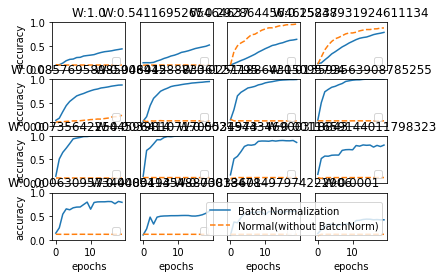

In [24]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

배치 정규화를 사용한 경우 실선, 배치 정규화 사용하지 않은 경우 점선 : 가중치 초깃값의 표준편차는 각 그래프 위에 표기했다.
![img](./deep_learning_images/fig_6-19.png)

* 거의 모든 경우, 배치 정규화 사용시 학습 진도가 빠르다.  
* 배치 정규화 미사용시, 가중치 초깃값이 잘 분포되어 있지 않으면 학습이 진행되지 않는다.


## 바른 학습을 위해
오버피팅(overfitting)  
### 오버피팅
* 발생하는 경우
    * 매개변수가 많고 표현력이 높은 모델(복잡한 모델)
    * 훈련 데이터가 적다

In [25]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True)

# 오버피팅을 재현하고자 학습 데이터 수를 줄인다.
x_train = x_train[:300]
t_train = t_train[:300]

In [26]:
#훈련 수행
network = MultiLayerNet(input_size = 784, hidden_size_list = [100, 100, 100, 100, 100, 100], output_size = 10)
optimizer = SGD(lr=0.01) #학습률이 0.01 SGD
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt +=1
        if epoch_cnt >= max_epochs:
            break

* train_acc_list, test_acc_list : 에폭 단위의 정확도를 저장한다.
![img](./deep_learning_images/fig_6-20.png)
* 훈련 데이터에만 적응(fitting)하여 범용 데이터에 제대로 대응하지 못한다.

### 가중치 감소
가중치 감소(weight decay)  
![img](./deep_learning_images/fig_6-21.png)
* 앞에 실험 결과와 비교하여 오버피팅이 억제됐다

### 드롭아웃
드롭아웃(Dropout)
![img](./deep_learning_images/fig_6-22.png)
[더 효율적인 구현](http://chainer.org/)

In [27]:
#드롭아웃
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

* 훈련 시 순전파에서 self.mask 삭제할 뉴런을 False로 표기
* self.mask  
x와 형상이 같은 배열 무작위 생성  
dropout_ratio보다 큰 원소만 True로 설정  
* 훈련시 역전파는 ReLU와 동일

In [28]:
#Mnist 적용
!cat ./overfit_dropout.py

# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_ac

train loss:2.311592756361231
=== epoch:1, train acc:0.11333333333333333, test acc:0.1081 ===
train loss:2.3054360908025195
train loss:2.3011535912698657
train loss:2.3142974361849866
=== epoch:2, train acc:0.11333333333333333, test acc:0.1087 ===
train loss:2.3190852927035435
train loss:2.307995552908178
train loss:2.308225231443041
=== epoch:3, train acc:0.11333333333333333, test acc:0.1098 ===
train loss:2.298744737684736
train loss:2.299301102739341
train loss:2.3045314829564245
=== epoch:4, train acc:0.12333333333333334, test acc:0.1115 ===
train loss:2.298311069768645
train loss:2.31097857821361
train loss:2.3159885231259163
=== epoch:5, train acc:0.12333333333333334, test acc:0.1126 ===
train loss:2.294907457826413
train loss:2.3069076173371887
train loss:2.2931704234769095
=== epoch:6, train acc:0.12333333333333334, test acc:0.1133 ===
train loss:2.3003590885087437
train loss:2.2991186558144423
train loss:2.2983861887583292
=== epoch:7, train acc:0.13, test acc:0.1152 ===
train 

train loss:2.2420469485149503
=== epoch:57, train acc:0.35, test acc:0.2698 ===
train loss:2.2621636165873618
train loss:2.266199365573657
train loss:2.2666308268719804
=== epoch:58, train acc:0.36, test acc:0.2739 ===
train loss:2.2686133182197614
train loss:2.2591500028151437
train loss:2.247890762885649
=== epoch:59, train acc:0.37, test acc:0.2758 ===
train loss:2.2562661396538375
train loss:2.262170194106456
train loss:2.266707751428658
=== epoch:60, train acc:0.36666666666666664, test acc:0.2773 ===
train loss:2.253937869617781
train loss:2.2390228967910204
train loss:2.2469510313189938
=== epoch:61, train acc:0.37666666666666665, test acc:0.281 ===
train loss:2.267429385098632
train loss:2.262227412868664
train loss:2.2663505462999267
=== epoch:62, train acc:0.37666666666666665, test acc:0.2824 ===
train loss:2.2591779623843093
train loss:2.256495118981658
train loss:2.249975897853541
=== epoch:63, train acc:0.37666666666666665, test acc:0.2838 ===
train loss:2.244116891631964
t

=== epoch:113, train acc:0.39666666666666667, test acc:0.3125 ===
train loss:2.1781779120994793
train loss:2.210939010795762
train loss:2.1577819884768856
=== epoch:114, train acc:0.39, test acc:0.3117 ===
train loss:2.17801689742071
train loss:2.187043435764337
train loss:2.193627112316141
=== epoch:115, train acc:0.39, test acc:0.3118 ===
train loss:2.1767161982483474
train loss:2.168346822983384
train loss:2.194758042654897
=== epoch:116, train acc:0.39, test acc:0.3106 ===
train loss:2.1926279022192374
train loss:2.19201990234809
train loss:2.1918343984258963
=== epoch:117, train acc:0.3933333333333333, test acc:0.3111 ===
train loss:2.1882162902935187
train loss:2.148141825157372
train loss:2.1812998816646645
=== epoch:118, train acc:0.3933333333333333, test acc:0.3129 ===
train loss:2.1680467649627473
train loss:2.1788412768717165
train loss:2.20684485632318
=== epoch:119, train acc:0.38333333333333336, test acc:0.3118 ===
train loss:2.175360198845557
train loss:2.18134091135325


train loss:2.062536151346103
train loss:2.040157581813963
=== epoch:169, train acc:0.41, test acc:0.3321 ===
train loss:2.0852541445775894
train loss:1.971764041990647
train loss:2.039117511276838
=== epoch:170, train acc:0.41333333333333333, test acc:0.3328 ===
train loss:2.0204904576986356
train loss:2.0423709215813877
train loss:1.9787829054983734
=== epoch:171, train acc:0.4166666666666667, test acc:0.3315 ===
train loss:1.9978784281344448
train loss:2.0151120705667416
train loss:2.0326901543167555
=== epoch:172, train acc:0.42, test acc:0.3306 ===
train loss:2.0289701440883414
train loss:2.006559609309039
train loss:1.9807545904182975
=== epoch:173, train acc:0.42, test acc:0.3304 ===
train loss:2.000359261268177
train loss:2.0143886157049464
train loss:2.02776590692773
=== epoch:174, train acc:0.42, test acc:0.3318 ===
train loss:2.0176562619372373
train loss:2.0491438957926023
train loss:2.035892149932539
=== epoch:175, train acc:0.42, test acc:0.3319 ===
train loss:2.0575958554

=== epoch:224, train acc:0.4766666666666667, test acc:0.3963 ===
train loss:1.6964440655091861
train loss:1.707941419959103
train loss:1.5655625683877679
=== epoch:225, train acc:0.48, test acc:0.3962 ===
train loss:1.6716352079417967
train loss:1.8000913083011543
train loss:1.5720454299703193
=== epoch:226, train acc:0.48, test acc:0.3969 ===
train loss:1.7380688223546341
train loss:1.7249728511725297
train loss:1.7249482300498429
=== epoch:227, train acc:0.48, test acc:0.3967 ===
train loss:1.7416246304677747
train loss:1.537291582215374
train loss:1.804407144539164
=== epoch:228, train acc:0.4866666666666667, test acc:0.3992 ===
train loss:1.7061795195888407
train loss:1.6503041684275974
train loss:1.7901332574907909
=== epoch:229, train acc:0.49333333333333335, test acc:0.4006 ===
train loss:1.7145172867818872
train loss:1.7164800760226182
train loss:1.7857752489931744
=== epoch:230, train acc:0.49333333333333335, test acc:0.405 ===
train loss:1.8014171418467917
train loss:1.656648

=== epoch:281, train acc:0.5633333333333334, test acc:0.4741 ===
train loss:1.350150835443838
train loss:1.4536675500824794
train loss:1.4425356933062758
=== epoch:282, train acc:0.5633333333333334, test acc:0.4734 ===
train loss:1.4122728597652208
train loss:1.4550424555378279
train loss:1.3426085217207335
=== epoch:283, train acc:0.5633333333333334, test acc:0.4745 ===
train loss:1.482144211713518
train loss:1.4195719188130715
train loss:1.4904596183785457
=== epoch:284, train acc:0.57, test acc:0.4767 ===
train loss:1.3415597373046202
train loss:1.320635781797424
train loss:1.3663816402722717
=== epoch:285, train acc:0.5633333333333334, test acc:0.4762 ===
train loss:1.3755380395565993
train loss:1.3809372412852248
train loss:1.4145191930003458
=== epoch:286, train acc:0.5633333333333334, test acc:0.477 ===
train loss:1.4088028550582237
train loss:1.4436730902138215
train loss:1.4208390525388606
=== epoch:287, train acc:0.5666666666666667, test acc:0.4802 ===
train loss:1.3685602790

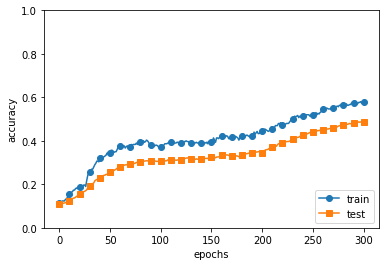

In [29]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

* 드롭아웃 여부 비교(dropout_ratio = 0.15)
![img](./deep_learning_images/fig_6-23.png)
* 앙상블 학습(ensemble learning)

## 적절한 하이퍼파라미터 값 찾기
### 검증 데이터

In [31]:
from common.util import shuffle_dataset
# 훈련 데이터 중 20%를 검증 데이터로 분리
(x_train, t_train), (x_test, t_test) = load_mnist()

# 뒤섞기
x_train, t_train = shuffle_dataset(x_train, t_train)

#20% split
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

### 하이퍼파라미터 최적화
* 하이퍼파라미터 값의 범위 설정
* 설정된 범위에서 하이퍼파라미터 값 무작위 추출
* 1단계에서 샘플링한 하이퍼파라미터 값으로 학습하고, 검증 데이터로 정확도 평가(에폭은 작게 설정)
* 1단계와 2단계 특정 횟수(100회 등) 반복하고, 그 정확도 결과를 보고 하이퍼파라미터 범위 좁히기

### 하이퍼파라미터 최적화 구현하기
* 하이퍼파라미터의 무작위 추출 코드

        weight_decay = 10 ** np,.random.uniform(-8, -4)
        lr = 10 ** np.random.uniform(-6, -2)
![img](./deep_learning_images/fig_6-24.png)

In [33]:
!python3 ./hyperparameter_optimization.py

val acc:0.8 | lr:0.006846041344311443, weight decay:8.186736507254628e-07
val acc:0.25 | lr:0.0021508103323164603, weight decay:9.685185781964833e-05
val acc:0.1 | lr:2.075257198977616e-05, weight decay:7.444147676156445e-07
val acc:0.23 | lr:0.0005747357369102754, weight decay:2.0896957587426936e-05
val acc:0.12 | lr:1.3159372444132892e-06, weight decay:7.941275544674768e-05
val acc:0.16 | lr:0.00036366653474057854, weight decay:1.695301705211217e-05
val acc:0.1 | lr:7.500343081676211e-05, weight decay:4.671315298580252e-06
val acc:0.14 | lr:0.000312596239801807, weight decay:3.0029662078204874e-08
val acc:0.08 | lr:9.491204636729138e-06, weight decay:6.505356625502383e-07
val acc:0.66 | lr:0.004177537957808198, weight decay:4.1643699763432515e-06
val acc:0.06 | lr:8.053159343867562e-06, weight decay:4.383218005794993e-08
val acc:0.08 | lr:6.22563976303766e-06, weight decay:3.173309070180226e-06
val acc:0.04 | lr:8.205760089939389e-05, weight decay:9.17167462546767e-06
val acc:0.18 | 

Best-10(val acc:0.69) | lr:0.005567702007251799, weight decay:7.853650707265631e-08
Best-11(val acc:0.66) | lr:0.004177537957808198, weight decay:4.1643699763432515e-06
Best-12(val acc:0.64) | lr:0.0060325844395631295, weight decay:7.830375927295806e-06
Best-13(val acc:0.63) | lr:0.004542380804985723, weight decay:4.778281004991148e-05
Best-14(val acc:0.62) | lr:0.0031499330426706332, weight decay:1.4666187961808213e-08
Best-15(val acc:0.58) | lr:0.002794859194909905, weight decay:1.9788739433988764e-07
Best-16(val acc:0.54) | lr:0.004223119136239191, weight decay:9.05710288704281e-08
Best-17(val acc:0.53) | lr:0.00335427610726913, weight decay:4.9798379331209144e-08
Best-18(val acc:0.49) | lr:0.003811212747374818, weight decay:1.1240727228516895e-08
Best-19(val acc:0.43) | lr:0.001392463480789716, weight decay:1.7294828449001888e-05
Best-20(val acc:0.42) | lr:0.0037407641571372647, weight decay:1.5906268495291236e-05
Figure(640x480)


    Best-1(val acc:0.84) | lr:0.006633674228511619, weight decay:1.6955036147903627e-07
    Best-2(val acc:0.8) | lr:0.006846041344311443, weight decay:8.186736507254628e-07
    Best-3(val acc:0.79) | lr:0.008049488230927838, weight decay:2.8666465700377217e-06
    Best-4(val acc:0.79) | lr:0.006578832253086749, weight decay:3.6368962596379066e-05
    Best-5(val acc:0.77) | lr:0.0077532149175545875, weight decay:1.913940595015841e-05
* 학습이 잘 진행될 때 하이퍼 파라미터
    * 학습률 : 0.001 ~ 0.01
    * 가중치 감소 계수 : $10^{-8}$ ~ $10^{-6}$  

## 정리
* 매개변수 갱신 방법 : 확률적 경사 하강법(SGD) 외에 모멘텀, AdaGrad, Adam 등이 있다.
* 가중치 초깃값을 정하는 방법은 올바른 학습을 하는 데 매우 중요하다.
* 가중치의 초깃값으로는 'Xavier 초깃값'과 'He 초깃값'이 효과적이다.
* 배치 정규화를 이용하면 학습을 빠르게 진행 및 초깃값 영향이 적어진다.
* 오버피팅 억제하는 정규화 기술로는 가중치 감소와 드롭아웃이 있다.
* 하이퍼파라미터 값 탐색은 최적 값이 존재할 법한 _범위를 점차 좁히면서_ 하는 것이 효과적이다.